Consider the model of a pendulum
$$
\dot{q} = \begin{bmatrix}
    \dot{\theta} \\
    \dot{\omega} 
\end{bmatrix} = 
\begin{bmatrix} 
    \omega \\
    -\frac{g}{l} \sin(\theta)
\end{bmatrix} = f(q).
$$

In [1]:
from math import sin, pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
def pendulum_dynamics(q):
    l = 1.0
    g = 9.81
    
    theta = q[0]
    theta_dot = q[1]
    
    theta_ddot = -(g/l)*sin(theta)
    
    return np.array([theta_dot, theta_ddot])

## Forward Euler
$$
\dot{q}(t) \approx \frac{q(t + \Delta t) - q(t)}{\Delta t}
$$
Let $q_k$ and $q_{k+1}$ denote $q(t)$ and $q(t + \Delta t)$, respectively.
$$
\begin{aligned}
    \frac{q_{k+1} - q_k}{\Delta t} &= f(q_k) \\
    q_{k+1} &= q_k + f(q_k) \Delta t 
\end{aligned}
$$


In [4]:
def forward_euler(dyn_fun, q0, Tf, dt):
    t = np.arange(0, Tf, dt)
    num_points = len(t)
    dim_x = len(q0)
    q_hist = np.zeros((dim_x, num_points))
    q_hist[:,0] = q0
    
    for k in range(num_points-1):
        q_hist[:,k+1] = q_hist[:,k] + dt*dyn_fun(q_hist[:,k])
        
    return q_hist, t

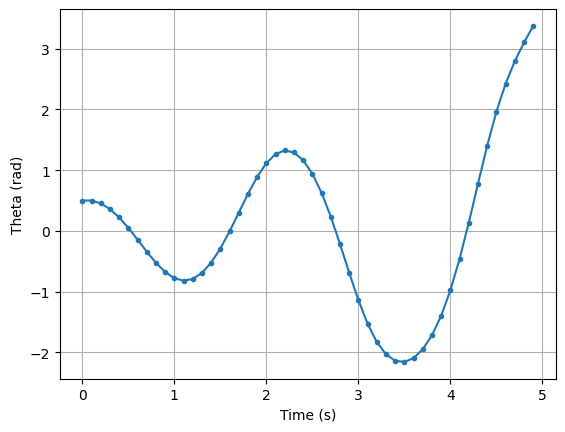

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
q0 = np.array([0.5, 0.])
q_hist, t_hist = forward_euler(pendulum_dynamics,
                               q0,
                               Tf=5,
                               dt=0.1)
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.grid()
plt.show()

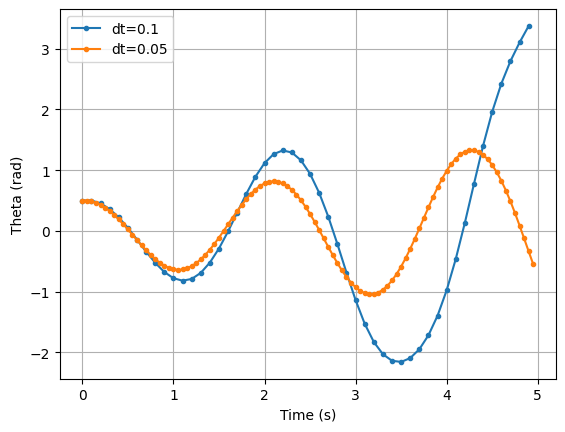

In [19]:
q0 = np.array([0.5, 0.])
q_hist_1, t_hist_1 = forward_euler(pendulum_dynamics,
                                   q0,
                                   Tf=5,
                                   dt=0.05)
plt.figure()
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3, label="dt=0.1")
plt.plot(t_hist_1, q_hist_1[0,:], "-o", markersize=3, label="dt=0.05")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()
plt.show()

## Forward Euler with input

In [6]:
def forward_euler_w_input(dyn_fun, q0, Tf, dt, u_fun=None):
    """
    Implements the Forward Euler method for numerical integration.
    
    Args:
        dyn_fun: Function of the form dyn_fun(q, u) -> dq/dt (state derivative)
        q0: Initial state (numpy array)
        Tf: Final time
        dt: Time step
        u_fun: Optional control input function u_fun(t), default=None
    
    Returns:
        q_hist: State trajectory over time
        t: Time vector
    """
    t = np.linspace(0, Tf, int(Tf/dt) + 1)  # Ensures Tf is included
    num_points = len(t)
    dim_x = len(q0)
    q_hist = np.zeros((dim_x, num_points))
    q_hist[:, 0] = q0  # Initial state

    for k in range(num_points - 1):
        q = q_hist[:, k]
        u = u_fun(t[k]) if u_fun else None  # Get input if provided
        
        dq = dyn_fun(q, u) if u is not None else dyn_fun(q)
        q_hist[:, k+1] = q + dt * np.array(dq)  # Ensure dq is a NumPy array

    return q_hist, t

In [7]:
def simple_dynamics(q):
    return np.array([-q[0]])  # Exponential decay

q0 = np.array([1.0])
Tf, dt = 5.0, 0.1
q_hist, t = forward_euler_w_input(simple_dynamics, q0, Tf, dt)

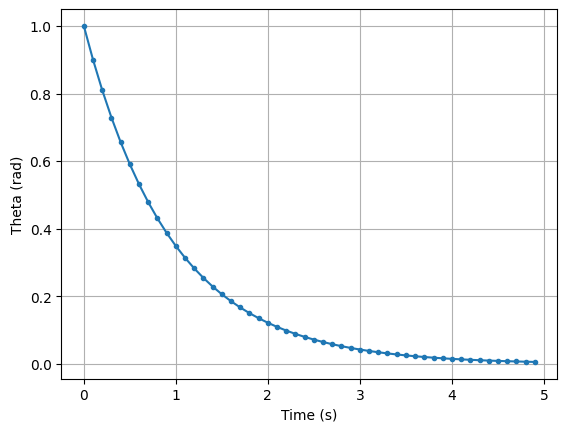

In [8]:
def controlled_dynamics(q, u):
    return np.array([-q[0] + u])  # Exponential decay with control

def my_control_law(t):
    return np.sin(t)  # Example control input

q_hist, t = forward_euler_w_input(simple_dynamics, q0, Tf, dt, u_fun=None)
plt.plot(t_hist, q_hist[0,:-1], "-o", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.grid()
plt.show()

## [Dynamics]: 2D Drone with Suspended Pendulum 

In [9]:
class Drone2DSimulation:
    def __init__(self, q0, Tf, dt, input_fun, method="euler"):
        self.q0 = q0
        self.Tf = Tf
        self.dt = dt
        self.input_fun = input_fun
        self.q_hist = None
        self.t_hist = None
        self.u_hist = None
        self.L_l = 1.5  # Length of the massless rod suspending the load (m)
        self.method = method  # Choose between 'euler' and 'rk4'

    def drone2D_dynamics(self, q, u):
        """
        Computes the dynamics of a 2D drone with suspended load.
        """
        m_d = 1.0  # Drone mass (kg)
        m_l = 0.1  # Load mass (kg)
        g = 9.81  # Gravity (m/s^2)
        d = 2.0  # Distance between rotors (m)
        I_d = 0.8  # Drone moment of inertia (kg*m^2)
        L_d = d / 2  # Distance from drone COM to each thruster (m)
        
        # Total mass
        m_tot = m_d + m_l

        # Baseline thrust for hovering
        baseline = m_tot * g / 2.0

        # Unpack state variables
        x, y, psi, theta, vx, vy, psi_dot, theta_dot = q
        u1, u2 = u  # Control inputs (added thrust deviations)

        # Compute actual thrusts
        F1 = baseline + u1
        F2 = baseline + u2
        F_T = F1 + F2  # Total thrust
        torque = L_d * (F2 - F1)  # Torque generated by thrust imbalance

        # Compute accelerations
        D_xy = -m_d**2 + m_d*m_l*np.sin(theta)**2 + m_d*m_l*np.cos(theta)**2 - 2*m_d*m_l + m_l**2 * np.sin(theta)**2 + m_l**2 * np.cos(theta)**2 - m_l**2
        D_theta = -self.L_l * m_d + self.L_l * m_l * np.sin(theta)**2 + self.L_l * m_l * np.cos(theta)**2 - self.L_l * m_l

        ddx = (F_T * (m_d*np.sin(psi) - m_l*np.sin(psi)*np.sin(theta)**2 + m_l*np.sin(psi) - m_l*np.sin(theta)*np.cos(psi)*np.cos(theta))
               + self.L_l * (-m_d*m_l*np.sin(theta)*theta_dot**2 + m_l**2 *np.sin(theta)**3 * theta_dot**2)
               + self.L_l * (m_l**2 * np.sin(theta) * np.cos(theta)**2 * theta_dot**2 - m_l**2 * np.sin(theta) * theta_dot**2)) / D_xy

        ddy = (F_T * (-m_d * np.cos(psi) + m_l*np.sin(psi)*np.sin(theta)*np.cos(theta) + m_l * np.cos(psi) * np.cos(theta)**2 - m_l*np.cos(psi))
               + g * (m_d**2 - m_d*m_l*np.sin(theta)**2 - m_d*m_l*np.cos(theta)**2 + 2*m_d*m_l - m_l**2 * np.sin(theta)**2 - m_l**2 * np.cos(theta)**2 + m_l**2)
               + self.L_l * (m_d*m_l*np.cos(theta)*theta_dot**2 - m_l**2 * np.sin(theta)**2 * np.cos(theta) * theta_dot**2 - m_l**2 * np.cos(theta)**3 * theta_dot**2 + m_l**2 * np.cos(theta) * theta_dot**2)) / D_xy

        ddtheta = F_T * (-np.sin(psi) * np.cos(theta) + np.cos(psi) * np.sin(theta)) / D_theta
        ddpsi = torque / I_d

        q_dot = np.array([vx, vy, psi_dot, theta_dot, ddx, ddy, ddpsi, ddtheta])

        return q_dot
    
    def forward_euler_w_input(self):
        """
        Performs forward Euler integration.
        """
        t_hist = np.arange(0, self.Tf, self.dt)
        num_points = len(t_hist)
        dim_x = len(self.q0)
        q_hist = np.zeros((dim_x, num_points))
        u_hist = np.zeros((2, num_points))
        q_hist[:, 0] = self.q0
        
        for k in range(num_points - 1):
            t_k = t_hist[k]
            u_k = self.input_fun(t_k)
            q_dot = self.drone2D_dynamics(q_hist[:, k], u_k)
            q_hist[:, k + 1] = q_hist[:, k] + self.dt * q_dot
            u_hist[:, k] = u_k

        self.q_hist = q_hist
        self.t_hist = t_hist
        self.u_hist = u_hist

        return q_hist, t_hist, u_hist

    def runge_kutta_w_input(self):
        """Performs Runge-Kutta 4 integration."""
        t_hist = np.arange(0, self.Tf, self.dt)
        num_points = len(t_hist)
        dim_x = len(self.q0)
        q_hist = np.zeros((dim_x, num_points))
        u_hist = np.zeros((2, num_points))
        q_hist[:, 0] = self.q0
        
        for k in range(num_points - 1):
            t_k = t_hist[k]
            u_k = self.input_fun(t_k)
            q_hist[:, k + 1] = self.rk4_step(q_hist[:, k], u_k)
            u_hist[:, k] = u_k

        self.q_hist = q_hist
        self.t_hist = t_hist
        self.u_hist = u_hist
        
        return q_hist, t_hist, u_hist

    def rk4_step(self, q, u):
        """Performs a single step of Runge-Kutta 4 integration."""
        k1 = self.drone2D_dynamics(q, u)
        k2 = self.drone2D_dynamics(q + 0.5 * self.dt * k1, u)
        k3 = self.drone2D_dynamics(q + 0.5 * self.dt * k2, u)
        k4 = self.drone2D_dynamics(q + self.dt * k3, u)
        return q + (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    def simulate(self):
        """Runs the simulation using the selected integration method."""
        if self.method == "euler":
            return self.forward_euler_w_input()
        elif self.method == "rk4":
            return self.runge_kutta_w_input()
        else:
            raise ValueError("Invalid integration method. Choose 'euler' or 'rk4'.")
    
    def plot_results(self, ):
        """
        Plots the simulation results.
        """
        state_labels = ["x (m)", "y (m)", "psi (rad)", "theta (rad)",
                        "vx (m/s)", "vy (m/s)", "psi_dot (rad/s)", "theta_dot (rad/s)"]
        plt.figure(figsize=(12, 8))
        for i in range(8):
            plt.subplot(4, 2, i + 1)
            plt.plot(self.t_hist, self.q_hist[i, :], "-o", markersize=3)
            plt.xlabel("Time (s)")
            plt.ylabel(state_labels[i])
            plt.grid()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(6, 4))
        plt.plot(self.t_hist, self.u_hist[0, :], label="u1 (Thrust 1)", color='blue')
        plt.plot(self.t_hist, self.u_hist[1, :], label="u2 (Thrust 2)", color='red')
        plt.xlabel("Time (s)")
        plt.ylabel("Control Inputs")
        plt.title("Control Inputs [u1, u2]")
        plt.legend()
        plt.grid()
        plt.show()
    
    def animate_trajectory(self):
        """
        Creates an animation of the drone trajectory.
        """
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_title("Drone Trajectory")
        line, = ax.plot([], [], 'bo-', markersize=3)

        def update_frame(frame):
            line.set_data(self.q_hist[0, :frame], self.q_hist[1, :frame])
            return line,

        ani = FuncAnimation(fig, update_frame, frames=len(self.t_hist), interval=100, blit=True)
        return HTML(ani.to_jshtml())

    def animate_dynamics(self):
        x_hist, y_hist, psi_hist, theta_hist = self.q_hist[0, :], self.q_hist[1, :], self.q_hist[2, :], self.q_hist[3, :]
        
        # Set up figure for animation
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.grid()
        
        # Initialize drone and load lines
        drone_body, = ax.plot([], [], "bo-", markersize=8, label="Drone Body")
        load_line, = ax.plot([], [], "r-", linewidth=2, label="Suspended Load")
        
        def update(frame):
            """ Update animation frame. """
            x, y, psi, theta = x_hist[frame], y_hist[frame], psi_hist[frame], theta_hist[frame]
            
            # Drone body points
            drone_x = [x - np.cos(psi), x + np.cos(psi)]
            drone_y = [y - np.sin(psi), y + np.sin(psi)]
            
            # Load position
            load_x = x + self.L_l * np.sin(theta)
            load_y = y - self.L_l * np.cos(theta)
        
            # Update elements
            drone_body.set_data(drone_x, drone_y)
            load_line.set_data([x, load_x], [y, load_y])
        
            return drone_body, load_line
            
        ani2 = animation.FuncAnimation(fig, update, frames=len(t_hist), interval=50, blit=True)
        return HTML(ani2.to_jshtml())

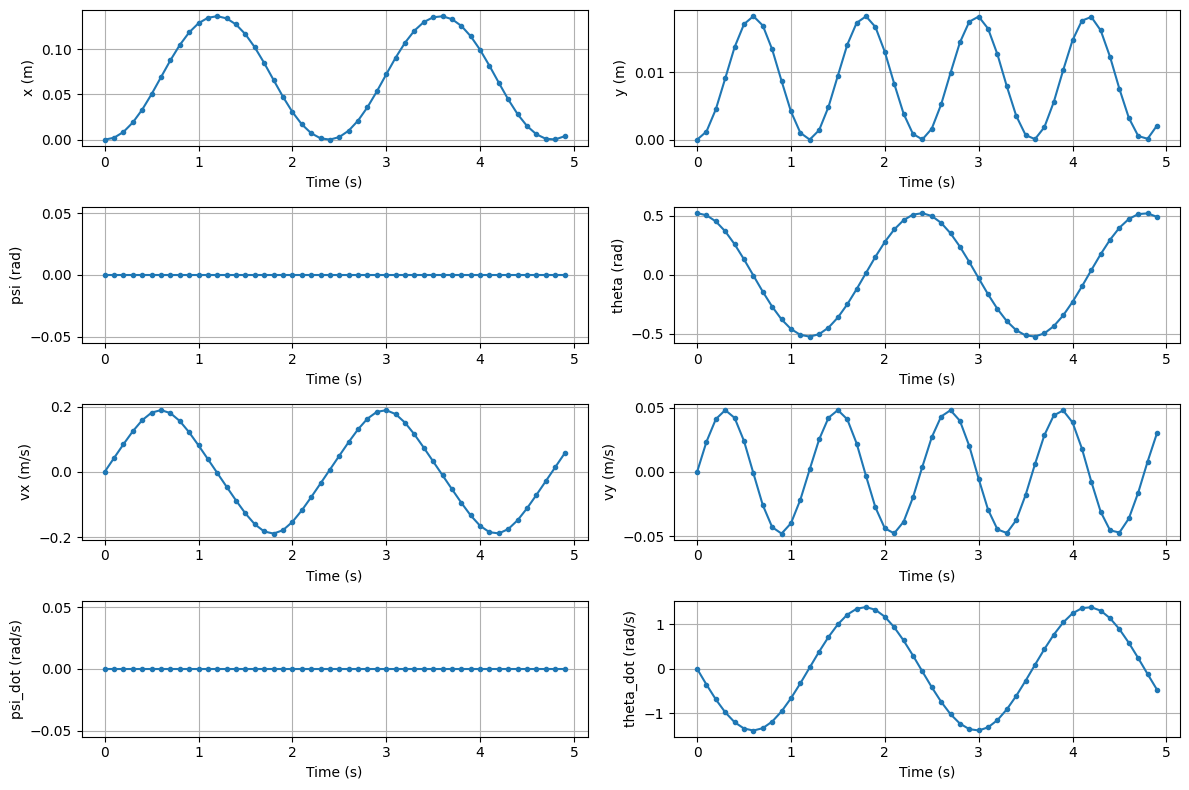

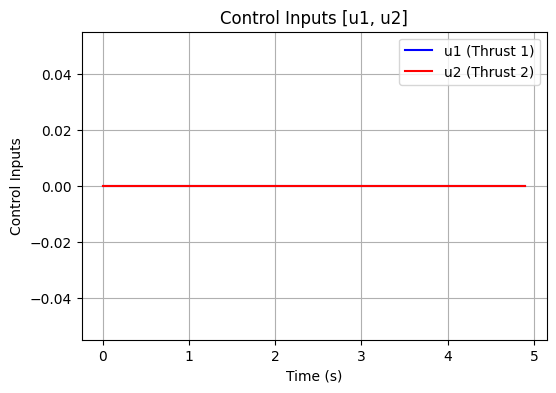

In [10]:
def input_fun(t):
    """
    Returns control inputs [u1, u2] as a function of time.
    - Initially, no extra thrust (hovering).
    - Later, a small force difference is introduced for tilting.
    """
    if t < 2.0:
        return np.array([0, 0])  # Perfect hover
    else:
        return np.array([0.0, 0.0])  # Apply differential thrust

# q0 = np.array([0, 0, 0, np.pi / 12, 0, 0, 0, 0])
# dt = 0.1
# Tf = 5.0

# sim = Drone2DSimulation(q0, Tf, dt, input_fun)
# sim.forward_euler_w_input()
# sim.plot_results()


# Initial conditions: [x, y, psi, theta, vx, vy, psi_dot, theta_dot]
q0 = np.array([0, 0, 0, np.pi / 6, 0, 0, 0, 0])

# Simulation parameters
Tf = 5.0  # Total simulation time
dt = 0.1  # Time step

# Run simulation with RK4
drone = Drone2DSimulation(q0, Tf, dt, input_fun, method="rk4")
q_hist, t_hist, u_hist = drone.simulate()
drone.plot_results()

In [11]:
HTML(drone.animate_trajectory().data)

In [12]:
HTML(drone.animate_dynamics().data)

# Runge–Kutta methods

We consider the 4th order Runge-Kutta method (RK4):
$$
\begin{aligned}
    k_1 &= f(q_k) \\
    k_2 &= f(q_k + 0.5 k_1 \Delta t) \\
    k_3 &= f(q_k + 0.5 k_2 \Delta t) \\
    k_4 &= f(q_k + k_3 \Delta t) \\
    q_{k+1} &= q_k + \frac{\Delta t}{6}(k_1 + 2 k_2 + 2 k_3 + k_4) 
\end{aligned}
$$

In [20]:
def fd_pendulum_rk4(qk, dt):
    f1 = pendulum_dynamics(qk)
    f2 = pendulum_dynamics(qk + 0.5*dt*f1)
    f3 = pendulum_dynamics(qk + 0.5*dt*f2)
    f4 = pendulum_dynamics(qk + dt*f3)
    return qk + (dt/6.0)*(f1 + 2*f2 + 2*f3 + f4)

def RK4(dyn_fun, q0, Tf, dt):
    t = np.arange(0, Tf, dt)
    num_points = len(t)
    dim_x = len(q0)
    q_hist = np.zeros((dim_x, num_points))
    q_hist[:,0] = q0
    
    for k in range(num_points-1):
        q_hist[:,k+1] = fd_pendulum_rk4(q_hist[:,k], dt)

    return q_hist, t

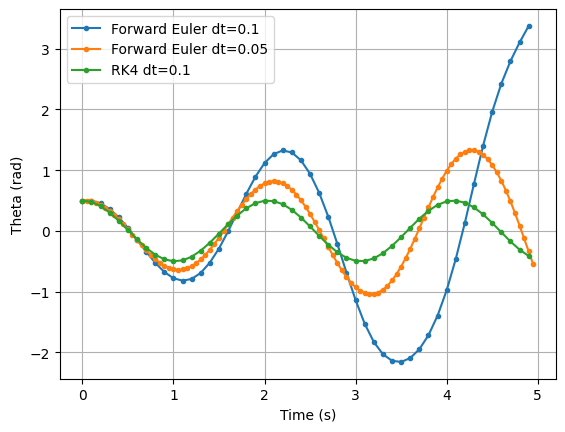

In [21]:
q_hist_rk, t_hist_rk = RK4(pendulum_dynamics, 
                           q0,
                           Tf=5,
                           dt=0.1)
plt.figure()
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3, label="Forward Euler dt=0.1")
plt.plot(t_hist_1, q_hist_1[0,:], "-o", markersize=3, label="Forward Euler dt=0.05")
plt.plot(t_hist_rk, q_hist_rk[0,:], "-o", markersize=3, label="RK4 dt=0.1")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()
plt.show()

# What's next?
- Semi-implicit Euler

- Implicit integration

- Collocation-based integration